In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt

from src.destot.DESTOT import align, xi_to_growth_rate
from src.destot.metrics import growth_distortion_metric, migration_metric
from src.destot.plotting import plot_slice_value


# Loading the Axolotl Telencephalon Slice Pair as AnnData Objects

The source for the stage 54 and stage 57 embryonic development datasets is https://db.cngb.org/stomics/artista/download/ under the file names Stage54.h5ad and Stage57.h5ad, which can be downloaded directly from the portal.

Alternatively, you can specify your directory of choice in the terminal and run the commands:

`wget https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000056/stomics/Stage54.h5ad target_directory`

`wget https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000056/stomics/Stage57.h5ad target_directory`

In [3]:
target_directory = '/n/fs/ragr-data/users/xinhao/axolotl/development/'

slice_54 = sc.read_h5ad(target_directory+'Stage54.h5ad')
slice_57 = sc.read_h5ad(target_directory+'Stage57.h5ad')

Our method works with AnnData objects. We assume that each input slice has an unnormalized gene expression count matrix stored in the `.X` field of the Anndata object, and spatial coordinates stored in the `.obsm['spatial']` field.

For this dataset, the unnormalized gene expression count matrix is stored in the `.layers['counts']` field, so we copy them to the `.X` field first.

In [4]:
slice_54.X = slice_54.layers['counts']
slice_57.X = slice_57.layers['counts']

# Run DeST-OT

The function `align` is the main function for running DeST-OT on a pair of AnnData objects. It will normalize the gene expressions and compute various cost matrices used in the optimization. If you have the cost matrices precomputed, you can directly call `destot_opt.LogSinkhorn_iteration` to return an alignment.

In [5]:
Pi, xi = align(slice_54, slice_57, alpha=0.2, gamma=50, epsilon=0.1, max_iter=100, 
               balanced=False, use_gpu=False, normalize_xi=True, check_convergence=False)

/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Iteration: 0
Iteration: 5
Iteration: 10
Iteration: 15
Iteration: 20
Iteration: 25
Iteration: 30
Iteration: 35
Iteration: 40
Iteration: 45
Iteration: 50
Iteration: 55
Iteration: 60
Iteration: 65
Iteration: 70
Iteration: 75
Iteration: 80
Iteration: 85
Iteration: 90
Iteration: 95


`align` returns two things. An alignment matrix `Pi` and a growth vector `xi`. Now let's visualize the returned growth for each cell from the first timepoint. If `normalize_xi=True` in `align`, `xi` will be normalized to number of descendant cells excluding the parent, otherwise it will be in units of probability mass. A value of 0 implies no division occurred, +1 that the parent divided into 2 cells, and -1 that the parent underwent apoptosis. As the method is probabilistic and spots pool many cells, the growth values are generally non-integral but can be viewed as describing the average/expected growth of cells within the spot.

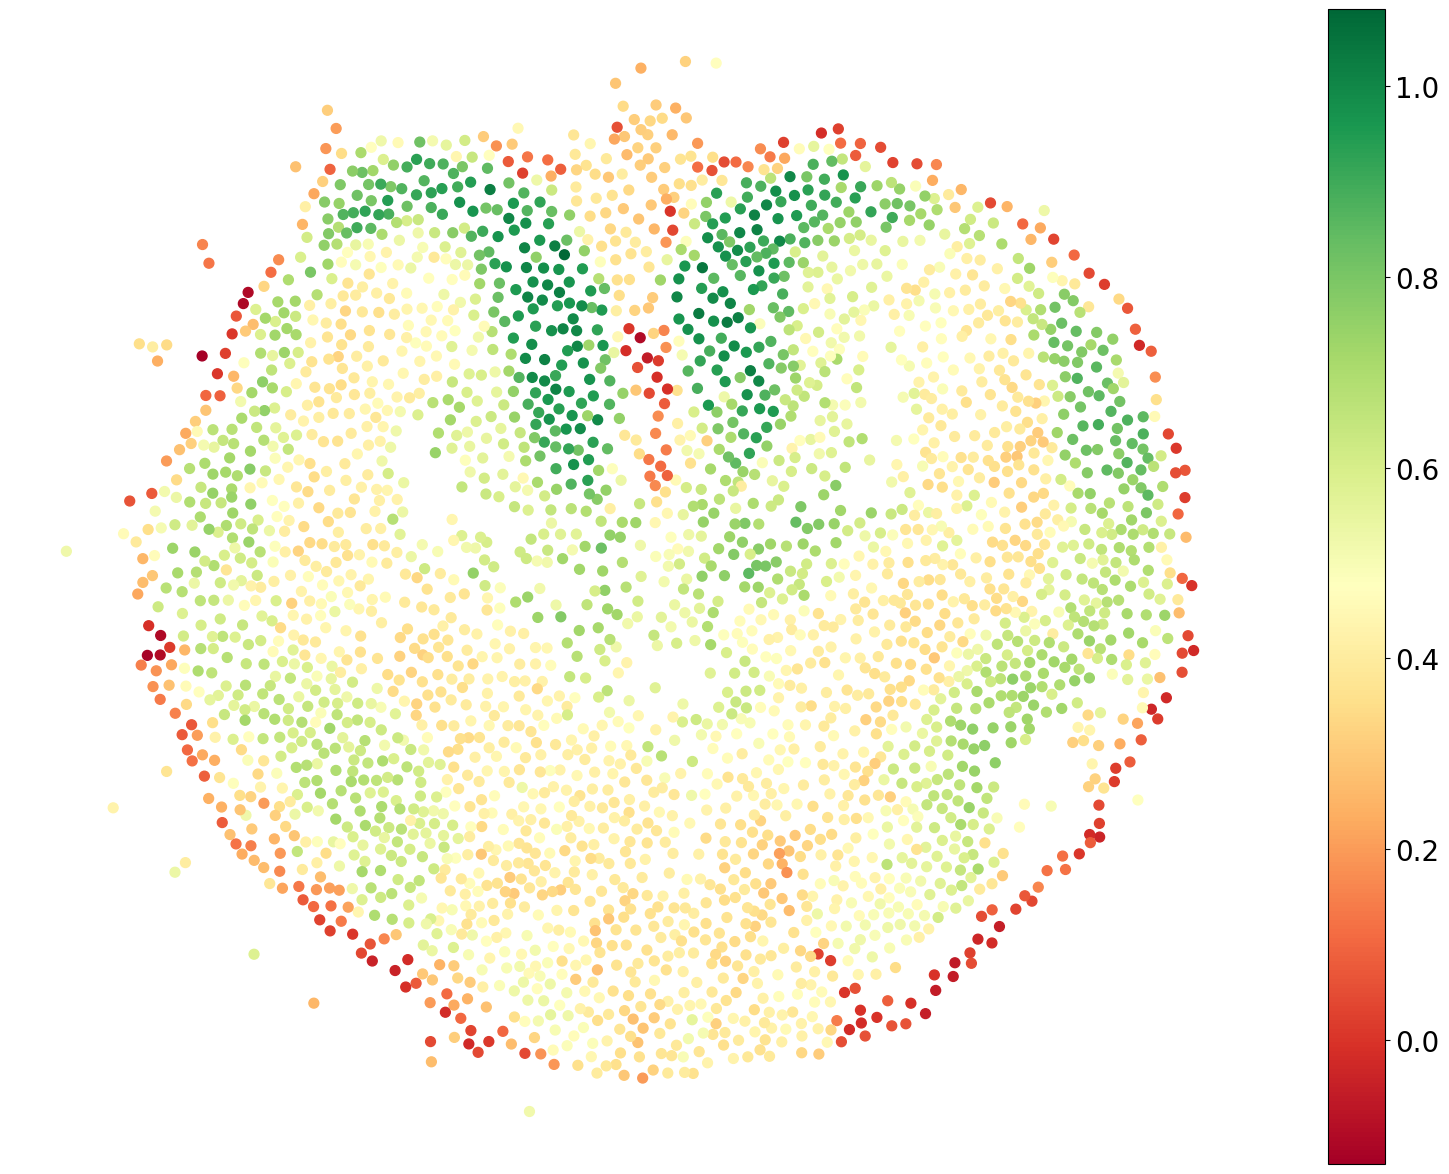

In [6]:
plot_slice_value(slice_54, xi)

# Metrics:

DeST-OT quantifies two metrics for assessing the biological plausibility of a _spatiotemporal_ alignment, the _growth-distortion metric_ and the _migration metric_. 

- The growth-distortion metric, denoted $\mathcal{J}_{\textrm{growth}}(\xi)$, quantifies the accuracy of the growth-rates learned from the alignment $\Pi$ using a ground-truth partition of the cell-types returned from any clustering algorithm.

- The migration metric, denoted $\mathcal{J}_{\textrm{migration}}(\Pi)$, quantifies the amount of spatial migration (distance travelled) by ancestor cells to their descendants under an alignment

We can easily compute the migration metric or growth distortion metric for any alignment $\Pi$. This alignment can come from any spatiotemporal alignment method.

To compute the migration metric, call `migration_metric` with the two AnnData objects and the alignment matrix as input

In [7]:
print(f'The cell migration distance between stage 54 and 57 is: {migration_metric(slice_54, slice_57, Pi)}')

The cell migration distance between stage 54 and 57 is: 504.00714127460776


There are two options for computing the growth rate distortion.

- A growth-rate distortion assuming diagonal transitions (i.e. that cells do not transition between types, as might be the case in non-developmental processes). This can be set with the argument `option="no_transition"`.


- The growth-rate distortion which the lowest possible under _any_ cell type transition. This option depends on the transition matrix which most accurately reflects the observed growth rates. This can be set with the argument `option="infer_transition"` $-$ we use this as a default and suggest this setting. This is particularly useful when the cell types at $t_1$ are not identical with the cell types at $t_2$.

To compute the growth distortion metric, call `growth_distortion_metric` with the two AnnData objects and the alignment matrix as input. Additionally, `annotation_key` is the key to the cell type information in the AnnData object. That is, `.obs[annotation_key]` stores the cell type of each cell.

In [13]:
from src.destot.metrics import growth_distortion_metric
print(f'The growth distortion metric of the DeST-OT alignment is: {growth_distortion_metric(slice_54, slice_57, Pi, annotation_key="Annotation")}');

/home/ph3641/DeST_OT_2/DeST_OT/src/destot/metrics.py:157: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if option == 'no_transition':


The growth distortion metric of the DeST-OT alignment is: 0.01453447530107214


Now let's visualize the distribution of the growth vector `xi`:

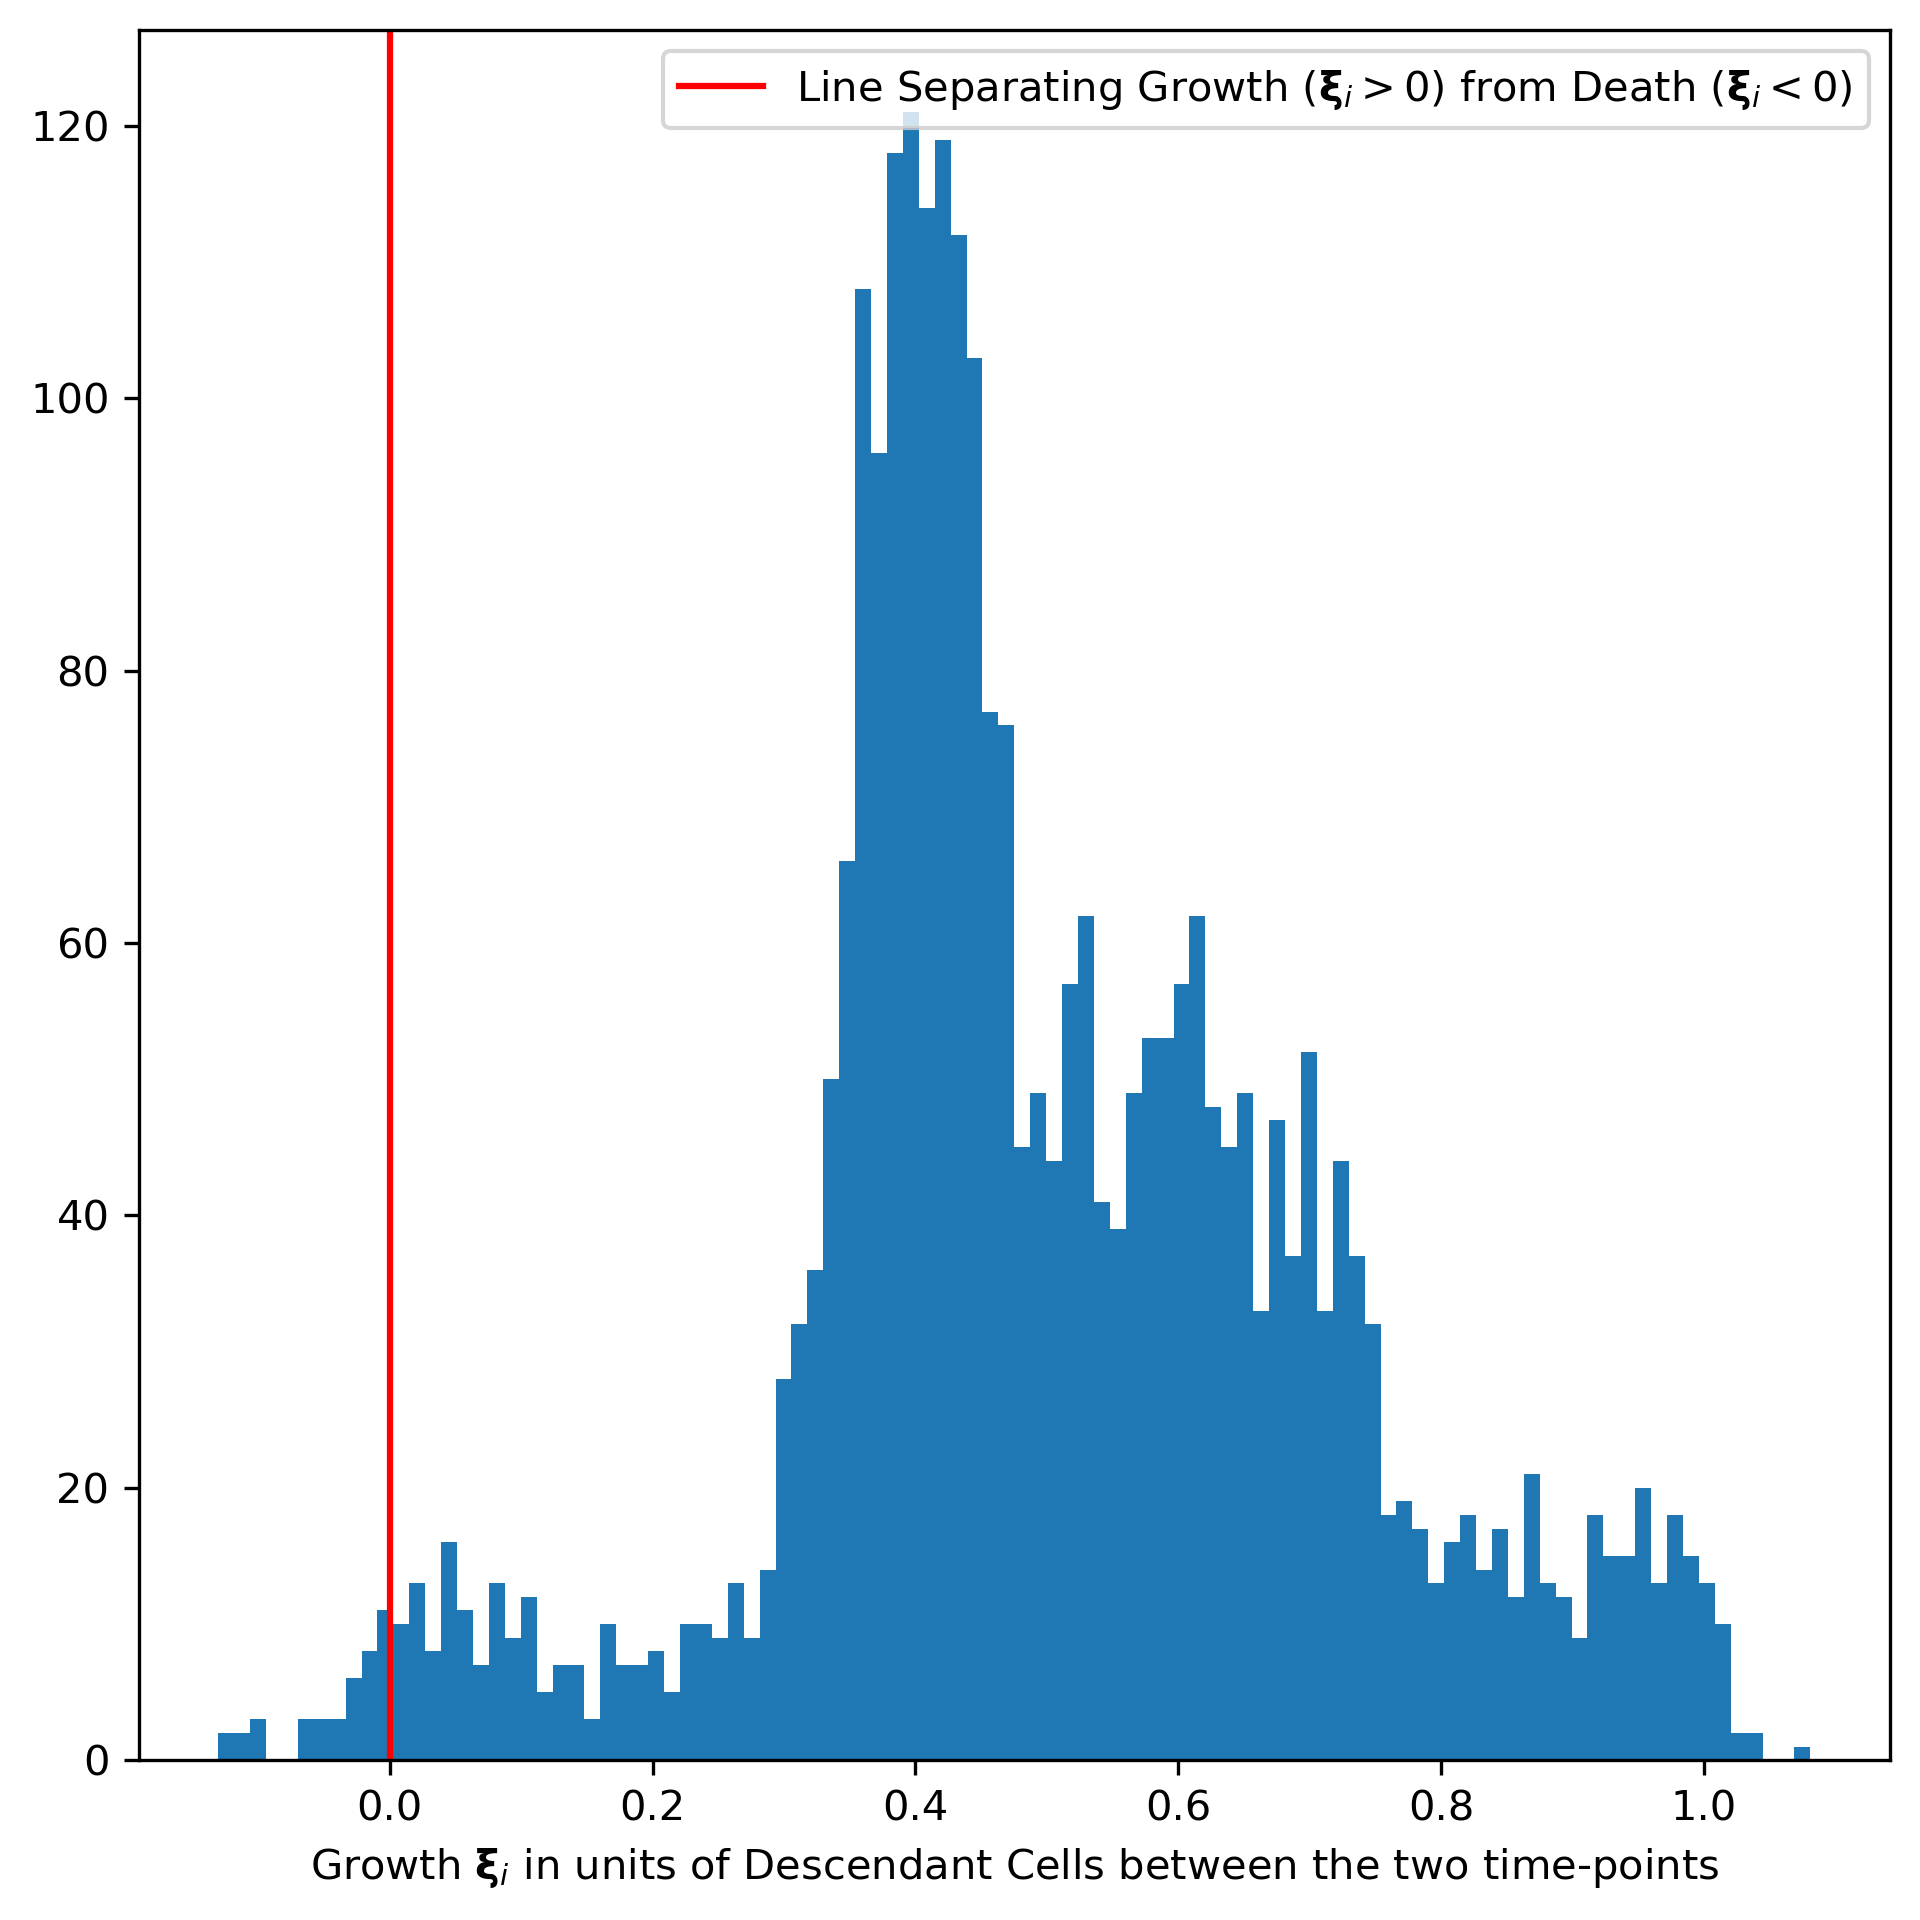

In [9]:
import numpy as np
plt.rcParams["figure.figsize"] = [6.50, 6.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 300
plt.hist(xi, bins=100)
plt.axvline(x=0, c='r', label=r'Line Separating Growth ($\mathbf{\xi}_{i} > 0$) from Death ($\mathbf{\xi}_{i} < 0$)')
plt.xlabel(r'Growth $\mathbf{\xi}_{i}$ in units of Descendant Cells between the two time-points')
plt.legend()
plt.show()

We can convert the growth vector `xi`, in unit of number of descendant cells, into a vector of growth rates for each cell from the first timepoint, by calling the `xi_to_growth_rate` function. We need to provide the two timepoints. For this dataset, the first timepoint is stage 54 of embryonic development, and the second timepoint is stage 57. So we input `t1=54`, `t2=57`.

We can visualize the growth rates returned for all cells in the first timepoint. As in the DeST-OT manuscript, we can analyze the differential pattern of growth rates by cell type as well.

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1378116/3017816034.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Growth Rates $J_{i}$ in units of $\mathrm{Stage}^{-1}$')


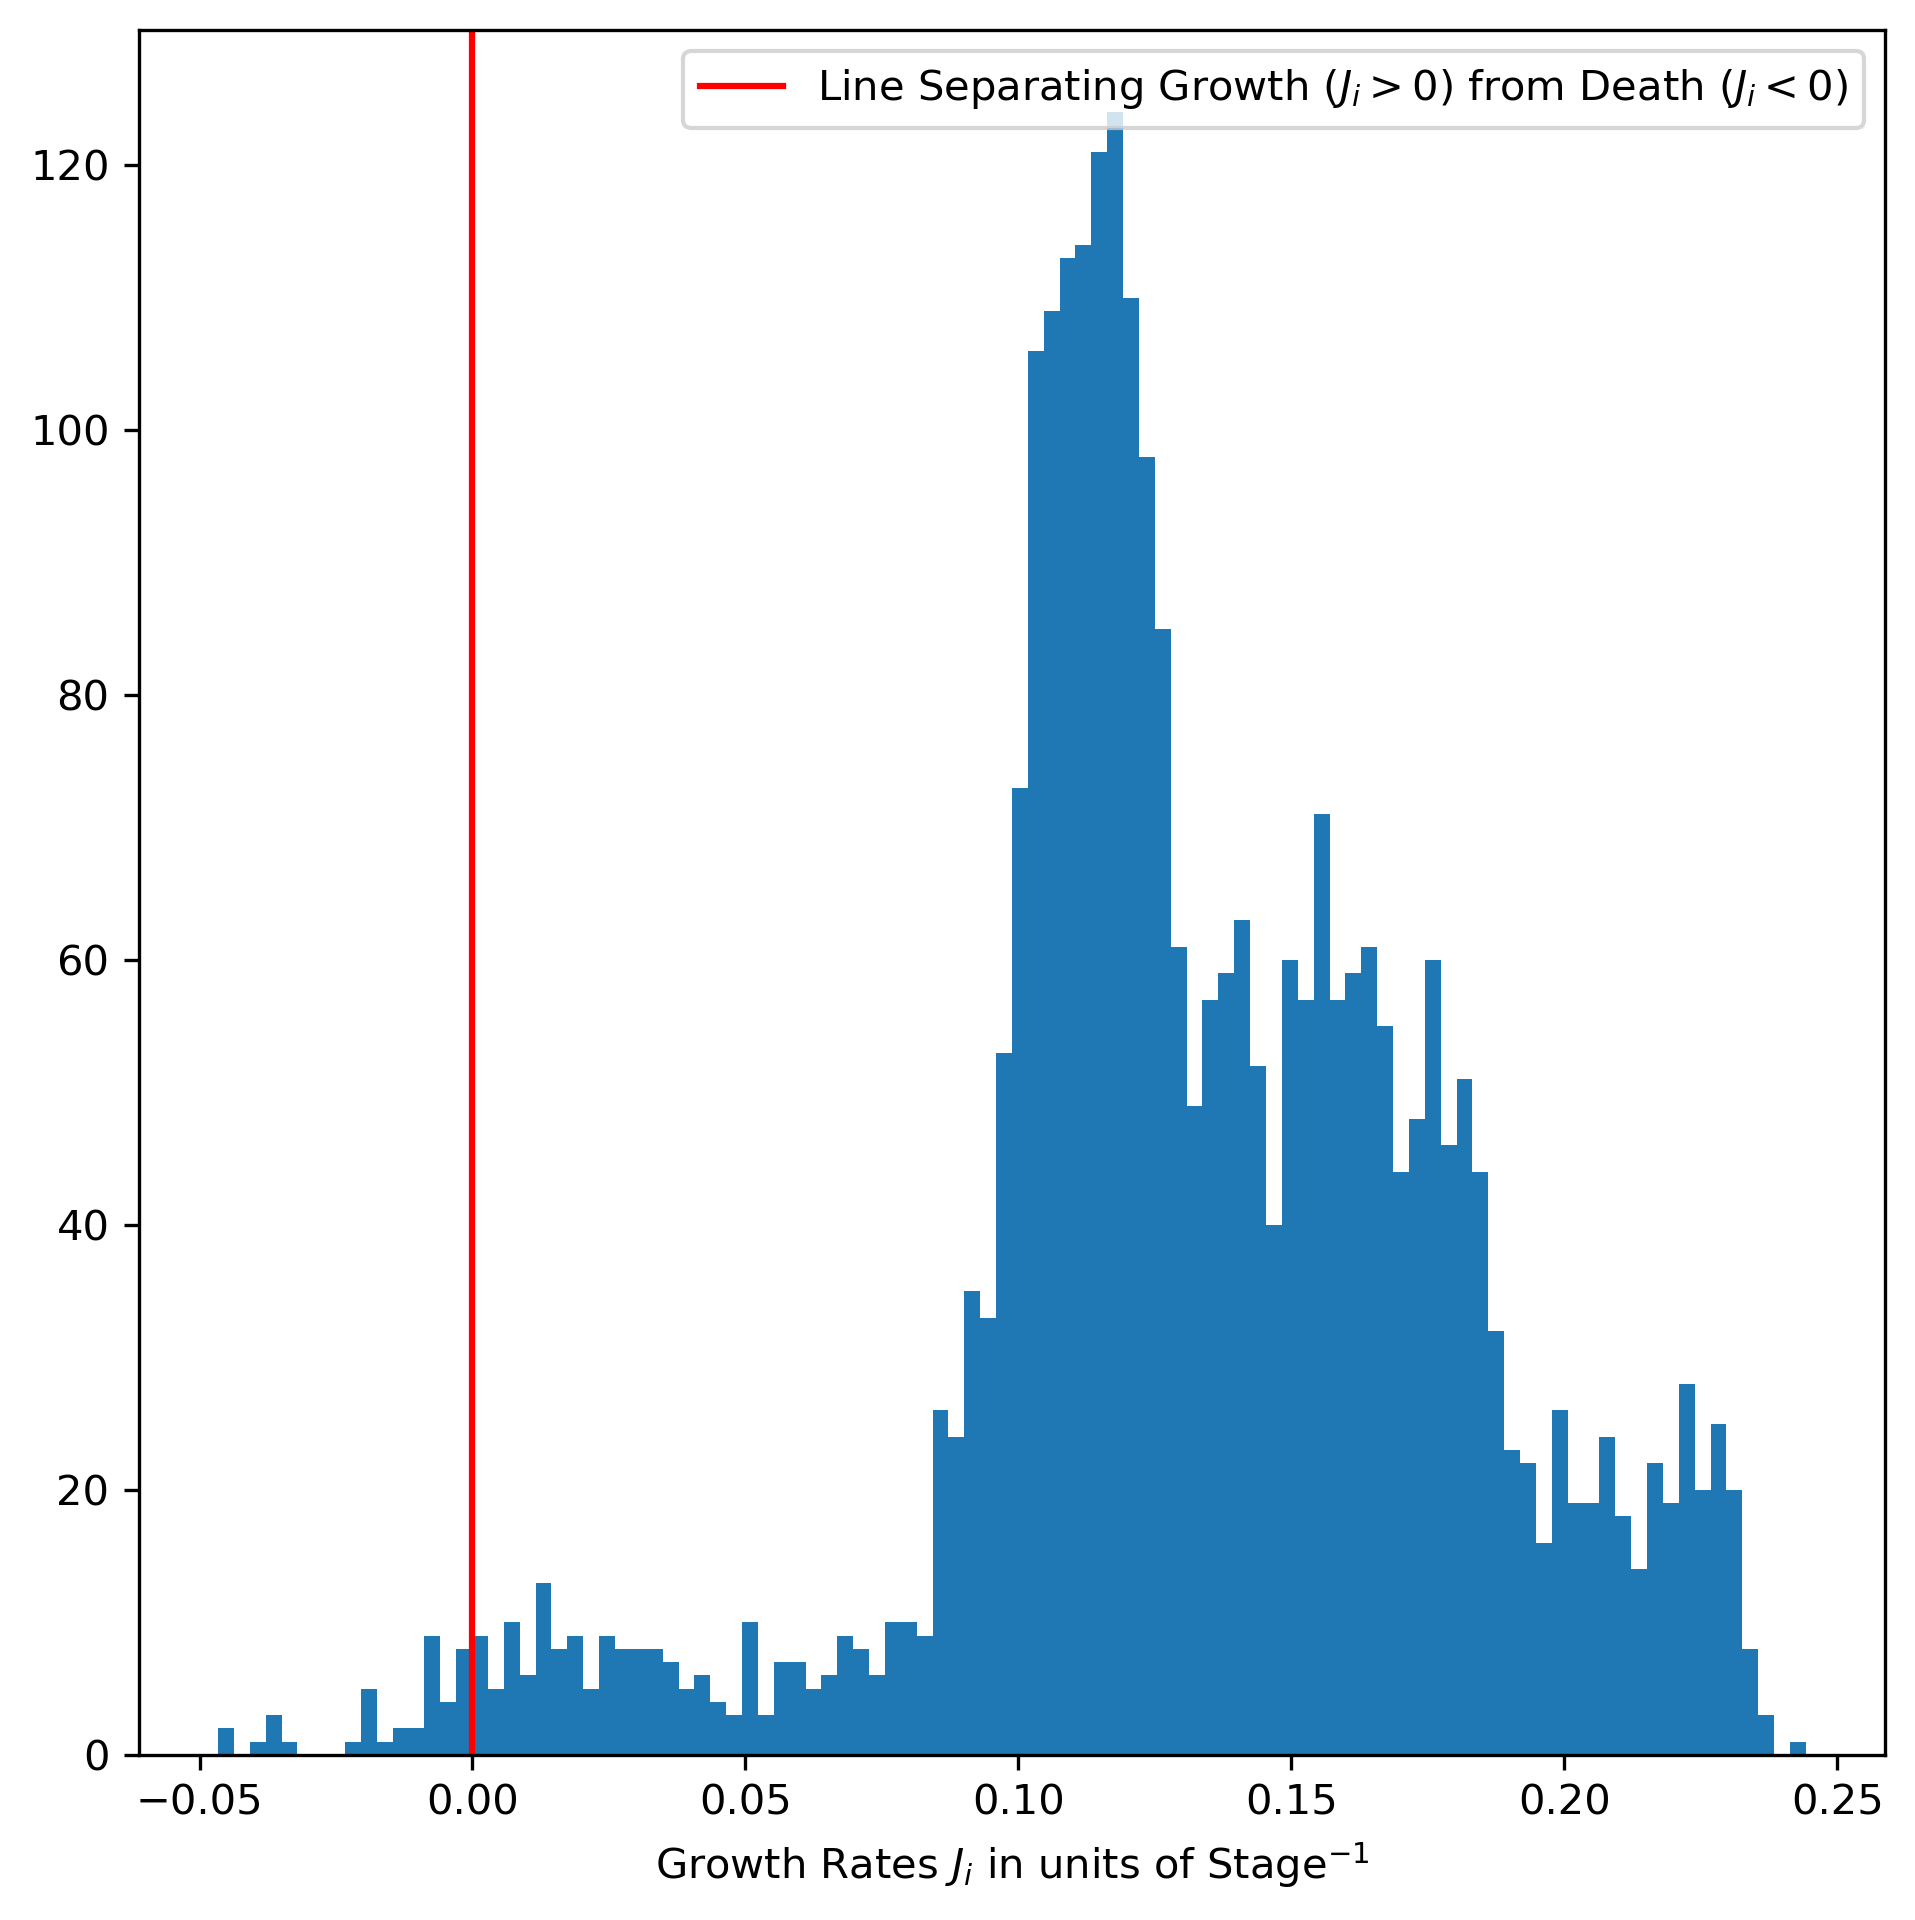

In [10]:
Js = xi_to_growth_rate(xi, t1=54, t2=57)
plt.hist(Js, bins=100)
plt.axvline(x=0, c='r', label='Line Separating Growth ($J_{i} > 0$) from Death ($J_{i} < 0$)')
plt.xlabel('Growth Rates $J_{i}$ in units of $\mathrm{Stage}^{-1}$')
plt.legend()
plt.show()

/home/ph3641/DeST_OT_2/DeST_OT/src/destot/plotting.py:61: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  categorical_labels, celltypes = pd.factorize(l_merged) # Getting numeric indices for the labels


'\n# If you have celltypes1 and celltypes2 manually annotated as np.ndarrays of shape of n1, n2 one can directly import:\n\nfrom src.destot.metrics import transition_mat\n\n# And compute the transition directly from the cell-type:\n\nT = transition_mat(Pi, celltypes1, celltypes2)\n'

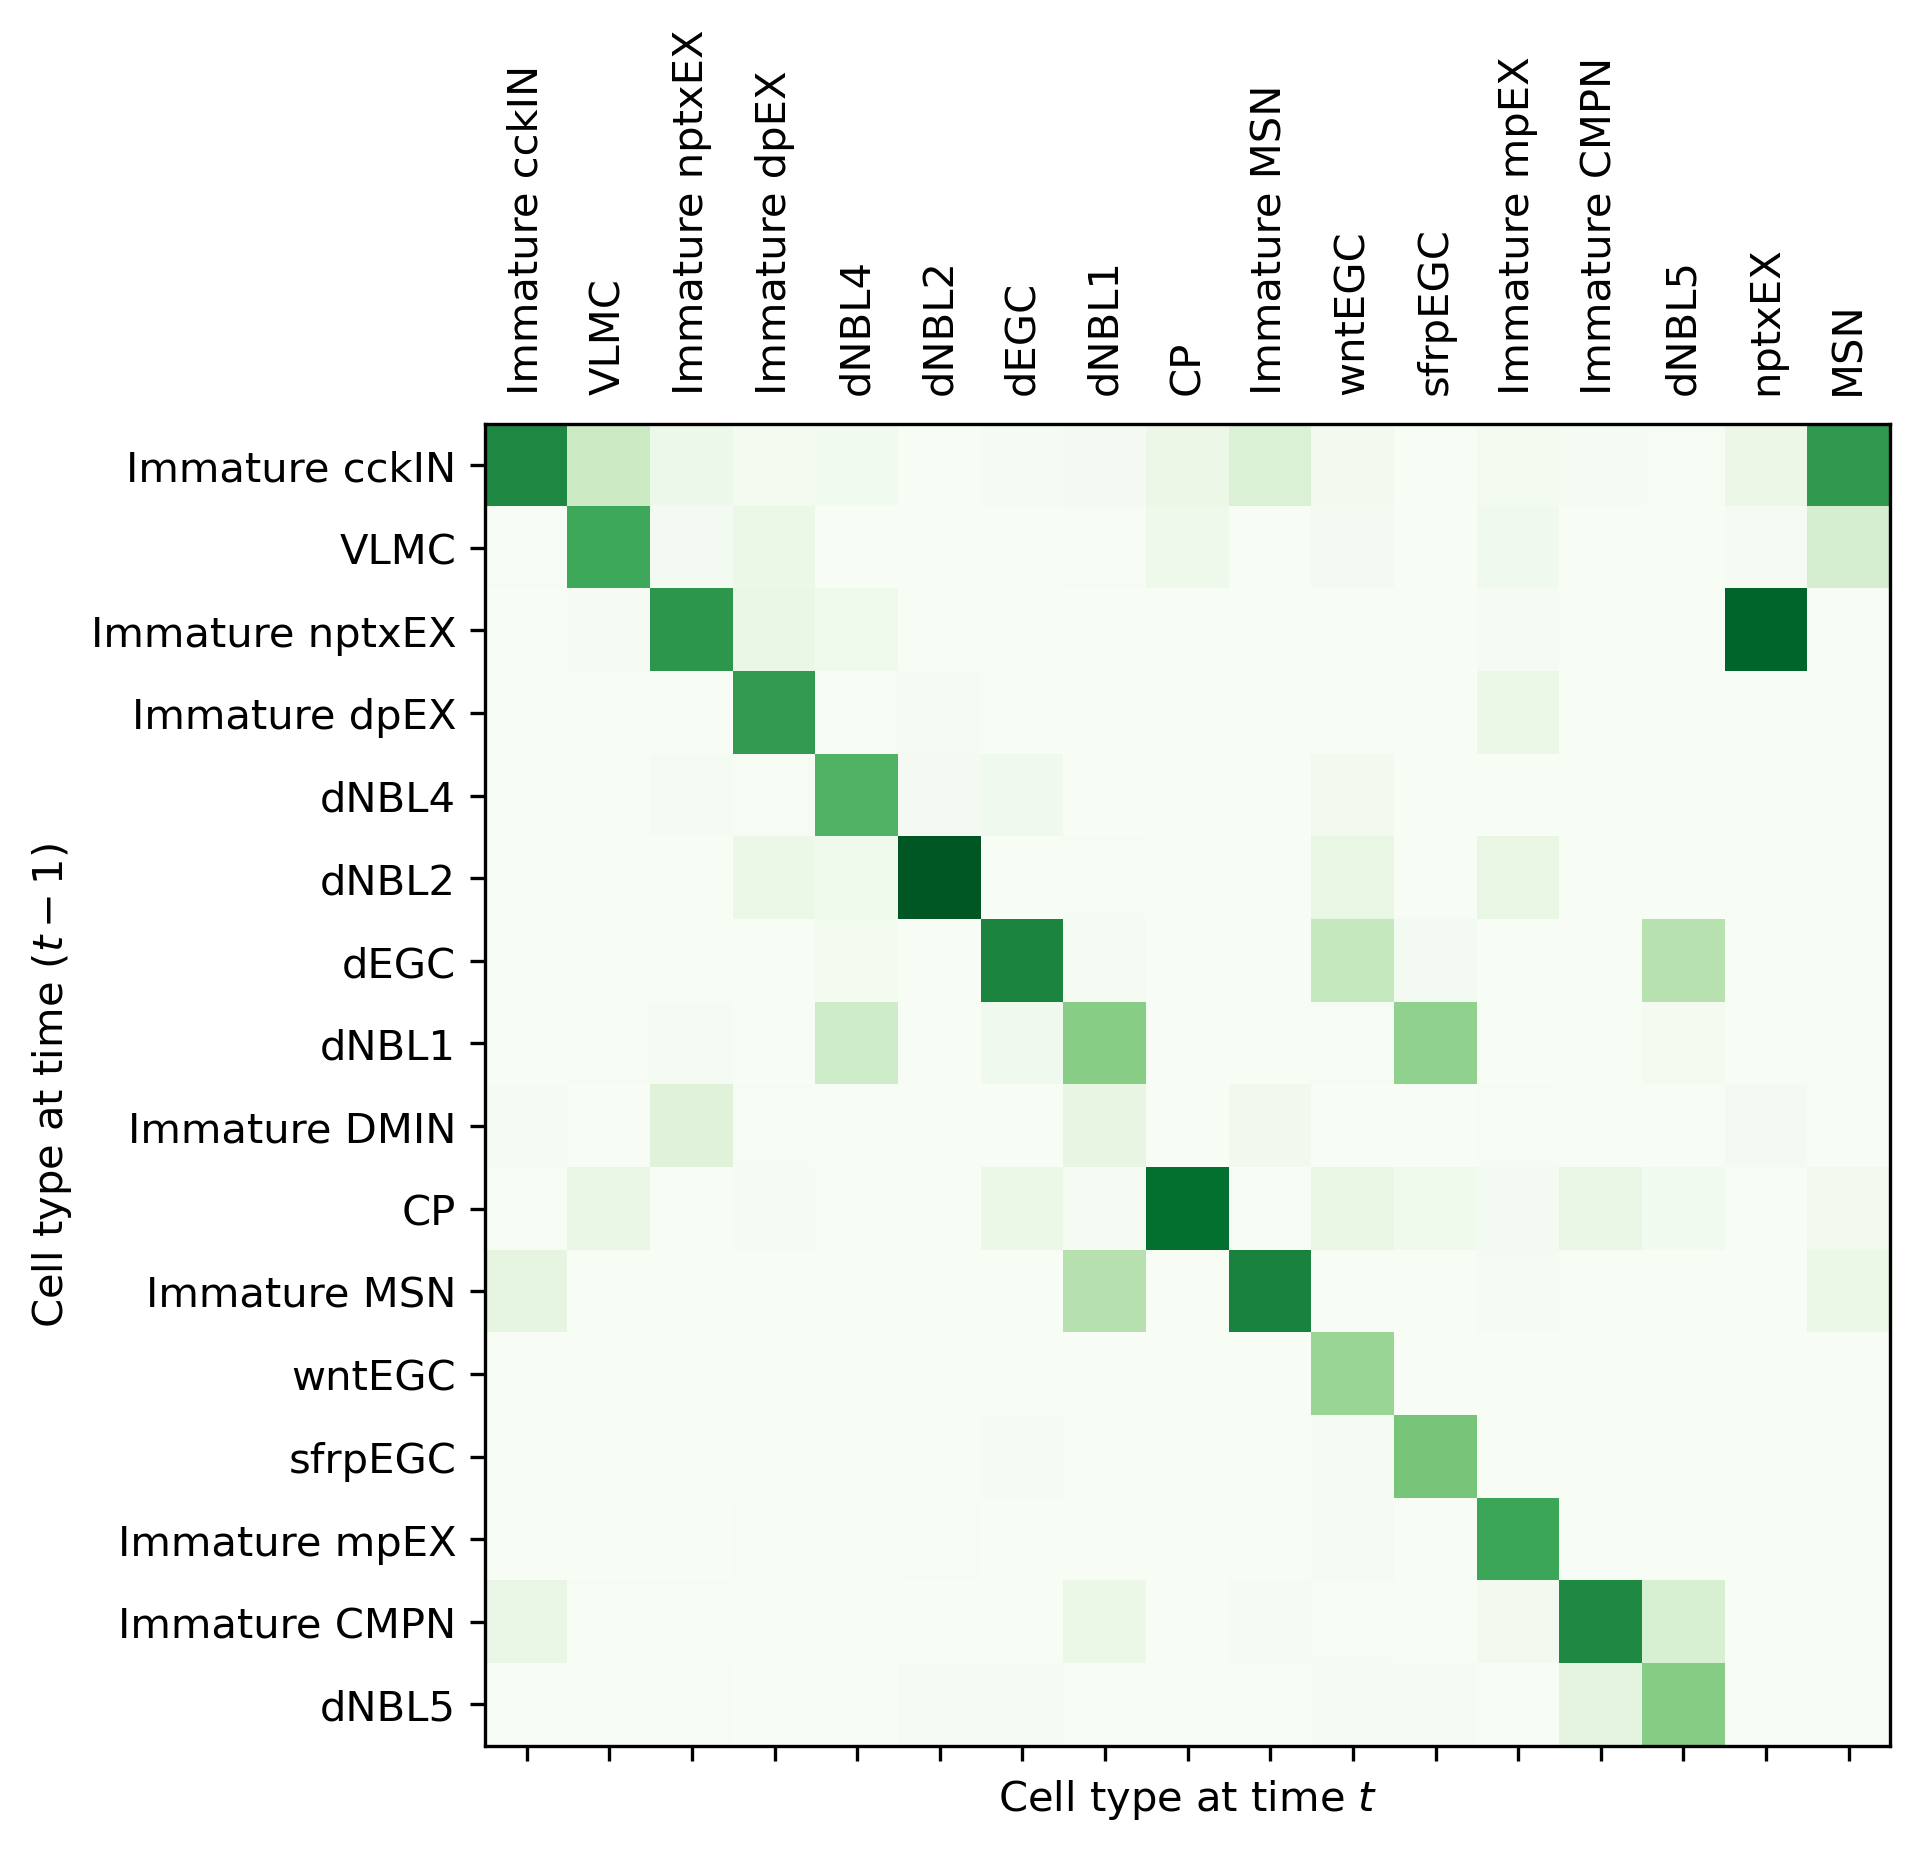

In [12]:
from src.destot.plotting import get_transition
import pandas as pd

"""
Yield transition matrix T, and labelsX + labelsY for time 1 + time2 cell-type labels 
ordered with the rows and columns of T. Set column = False to visualize the transitions in row-normalized form instead.
"""

T, labelX, labelY = get_transition(Pi, slice_54, slice_57, 
                                   annotation_key = 'Annotation', 
                                   plotting=True, column = True)

"""
# If you have celltypes1 and celltypes2 manually annotated as np.ndarrays of shape of n1, n2 one can directly import:

from src.destot.metrics import transition_mat

# And compute the transition directly from the cell-type:

T = transition_mat(Pi, celltypes1, celltypes2)
"""